# CS M152A MNIST CLASSIFIER

In [229]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, autograd
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Data normalization transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load MNIST
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [230]:
class MNIST_compressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 4, stride = 4)
        self.conv1.weight.data.fill_(1/16)
        self.conv1.bias.data.fill_(0)
    def forward(self, x):
        m = nn.ConstantPad2d(2, -1)
        x = self.conv1(m(x))
        return x

In [231]:
n_hidden = 100
n_output = 10
n_input = 64
classifier = nn.Sequential(nn.Linear(n_input, n_hidden),
                           nn.ReLU(),
                           nn.Linear(n_hidden, n_output),
                           nn.LogSoftmax(dim=1))

In [271]:
mnist_compression = MNIST_compressor()
criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.Adam(classifier.parameters(), lr=0.003)
t = torch.Tensor([-0.5])
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = mnist_compression(images).detach()
        images = images.view(images.shape[0], -1)
        images = (images > t).float()
        optimizer.zero_grad()
        output = classifier(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5587042162635687
Training loss: 0.4337855109940968
Training loss: 0.40445027323261
Training loss: 0.38861499323265386
Training loss: 0.3784666147980609


tensor(6)
tensor([[2.2672e-04, 1.5408e-06, 1.9849e-03, 3.4204e-05, 2.5780e-03, 1.5233e-03,
         9.8876e-01, 1.3206e-08, 4.8962e-03, 4.1845e-08]])


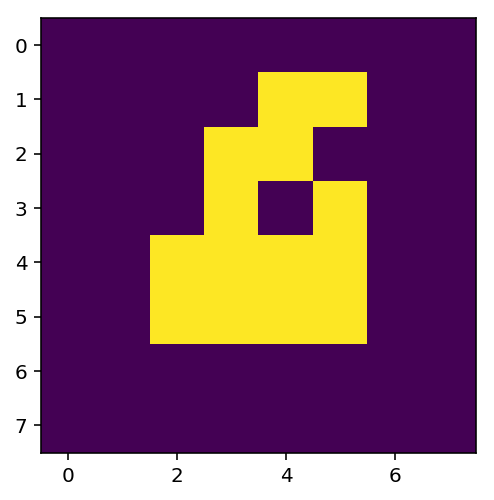

In [303]:
%matplotlib inline
import helper
imagenum = 8
images, labels = next(iter(trainloader))

images = mnist_compression(images).detach()
images = images.view(images.shape[0], -1)
images = (images > t).float()
img = images[imagenum].view(1, 64)
print(labels[imagenum])
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = classifier(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
plt.imshow(img.view(1, 8, 8).numpy().squeeze())
print(ps)